# Работа по теме "Численное прогнозирование"

## Описание

Работа предполагает самостоятельное исследование данных и построение регрессионных моделей.

Основная задача работы - научиться работать с методами численного прогнозирования, настраивать и отбирать лучшие модели.

Предлагается один набор данных.

Примерные критерии оценки:
- представленные данные изучены и описаны;
- данные предобработаны при необходимости, разделены на выборки;
- верно проведена обработка категориальных данных;
- рассмотрено не менее трех различных методов регрессии;
- создаваемые модели настроены для получения наилучших результатов;
- рассмотрены различные метрики для оценки, при описании результатов метрики верно интерпретированы.

В результате необходимо получить наилучшую модель численного прогнозирования, при этом основную метрику разрешается выбрать самостоятельно, объяснив свой выбор. Также должен быть показан весь процесс выбора и настройки моделей.

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

# Анализ доходов домохозяйств

Набор данных `household_income.csv`.

Описание данных:
- Age: Age of the primary household member (18 to 70 years).
- Education Level: Highest education level attained (High School, Bachelor's, Master's, Doctorate).
- Occupation: Type of occupation (Healthcare, Education, Technology, Finance, Others).
- Number of Dependents: Number of dependents in the household (0 to 5).
- Location: Residential location (Urban, Suburban, Rural).
- Work Experience: Years of work experience (0 to 50 years).
- Marital Status: Marital status of the primary household member (Single, Married, Divorced).
- Employment Status: Employment status of the primary household member (Full-time, Part-time, Self-employed).
- Household Size: Total number of individuals living in the household (1 to 7).
- Homeownership Status: Homeownership status (Own, Rent).
- Type of Housing: Type of housing (Apartment, Single-family home, Townhouse).
- Gender: Gender of the primary household member (Male, Female).
- Primary Mode of Transportation: Primary mode of transportation used by the household member
(Car, Public transit, Biking, Walking).
- Income: Actual annual household income, derived from a combination of features
with added noise. Unit USD

Целевая переменная - Income.

Требуется построить наилучшую модель для прогнозирования доходов домохозяйств.

In [7]:
# Загрузка данных
df = pd.read_csv('household_income.csv')

# Проверка фактических названий столбцов
print("Фактические названия столбцов:")
print(df.columns.tolist())

# Переименование столбцов для соответствия описанию
column_mapping = {
    'Work_Experience': 'Work Experience',
    'Household_Size': 'Household Size',
    'Number_of_Dependents': 'Number of Dependents',
    # Добавьте другие несоответствия при необходимости
}

df = df.rename(columns=column_mapping)

# Предварительный анализ данных
print("\nПервые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe(include='all'))
print("\nПропущенные значения:")
print(df.isnull().sum())



Фактические названия столбцов:
['Age', 'Education_Level', 'Occupation', 'Number_of_Dependents', 'Location', 'Work_Experience', 'Marital_Status', 'Employment_Status', 'Household_Size', 'Homeownership_Status', 'Type_of_Housing', 'Gender', 'Primary_Mode_of_Transportation', 'Income']

Первые 5 строк данных:
   Age Education_Level  Occupation  Number of Dependents Location  \
0   56        Master's  Technology                     5    Urban   
1   69     High School     Finance                     0    Urban   
2   46      Bachelor's  Technology                     1    Urban   
3   32     High School      Others                     2    Urban   
4   60      Bachelor's     Finance                     3    Urban   

   Work Experience Marital_Status Employment_Status  Household Size  \
0               21        Married         Full-time               7   
1                4         Single         Full-time               7   
2                1         Single         Full-time               7

<Figure size 1200x800 with 0 Axes>

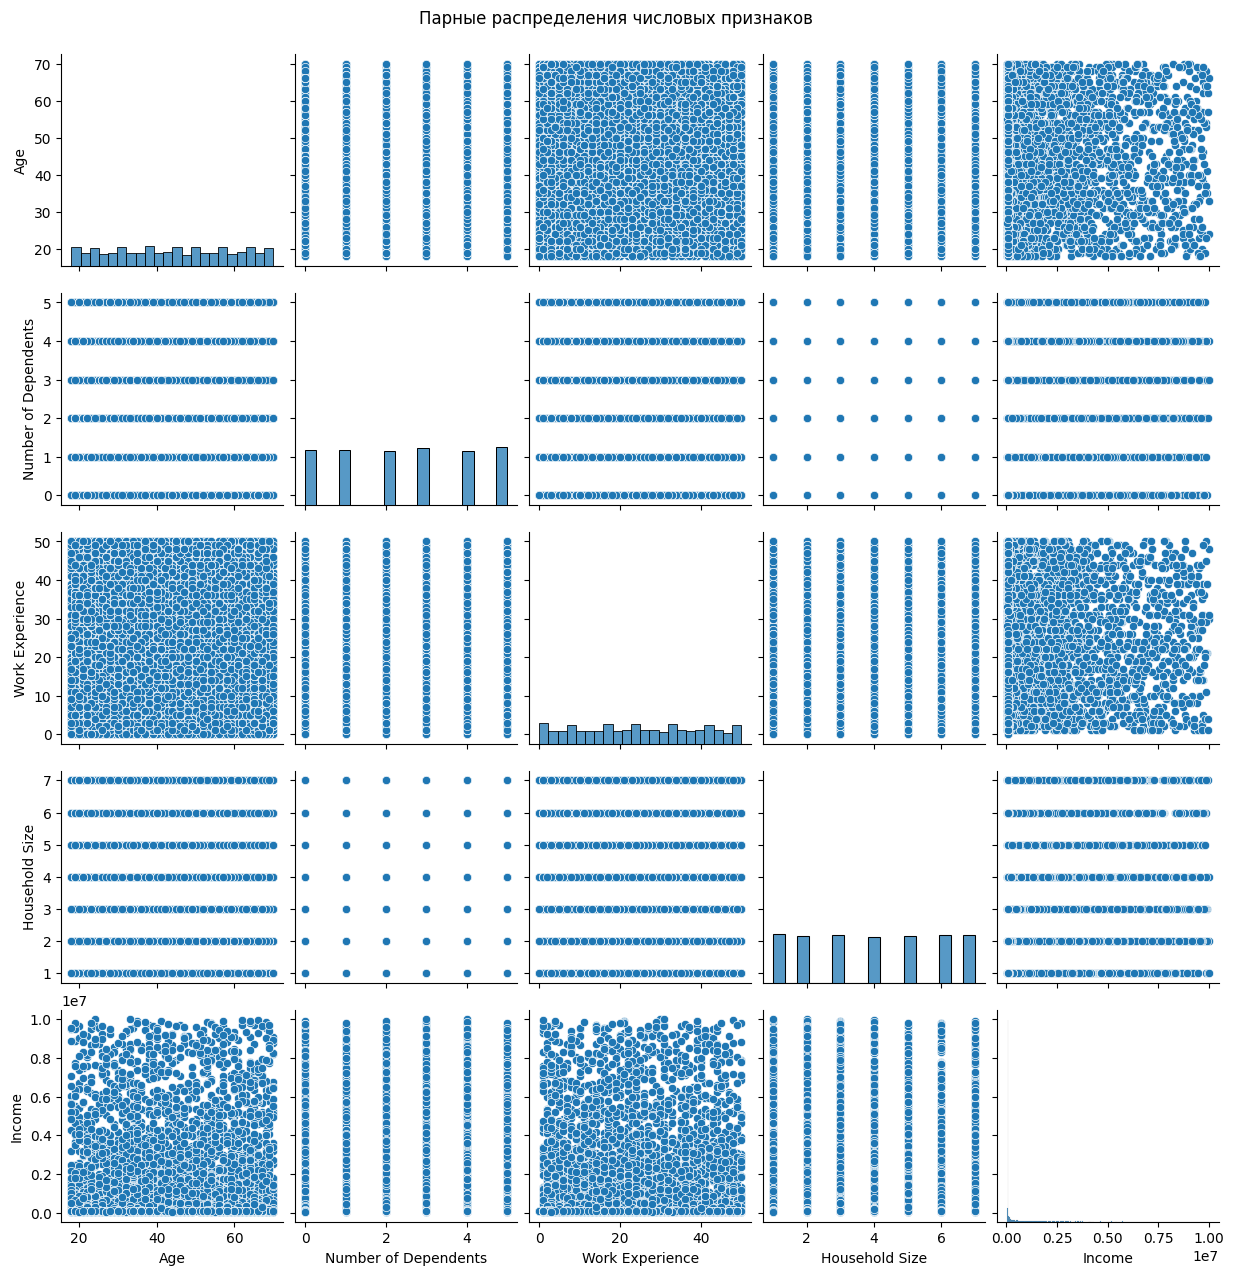

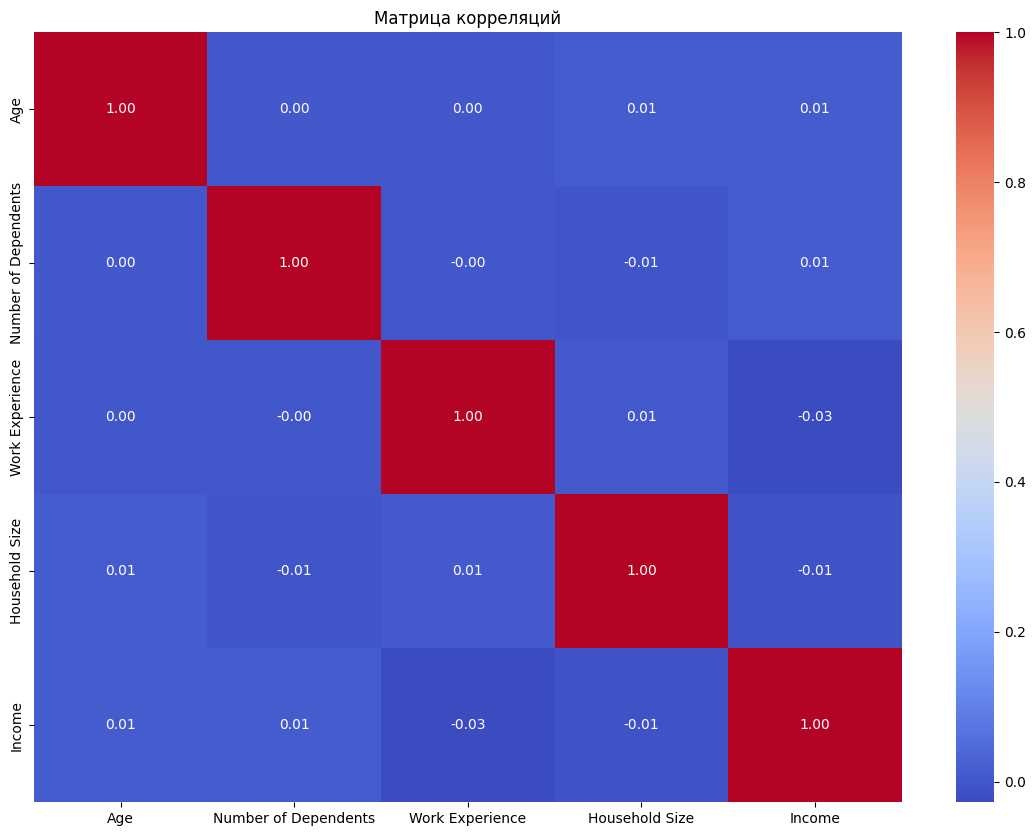


Категориальные признаки: ['Education_Level', 'Occupation', 'Location', 'Marital_Status', 'Employment_Status', 'Homeownership_Status', 'Type_of_Housing', 'Gender', 'Primary_Mode_of_Transportation']
Числовые признаки: ['Age', 'Number of Dependents', 'Work Experience', 'Household Size']


In [8]:
# Визуализация данных
# Выбор числовых столбцов
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'Income' in numeric_cols:
    numeric_cols.remove('Income')
    numeric_cols.append('Income')  # Перемещаем Income в конец

if numeric_cols:
    plt.figure(figsize=(12, 8))
    sns.pairplot(df[numeric_cols])
    plt.suptitle('Парные распределения числовых признаков', y=1.02)
    plt.show()

    plt.figure(figsize=(14, 10))
    sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Матрица корреляций')
    plt.show()
else:
    print("Нет числовых столбцов для визуализации")

# Подготовка данных
# Разделение на признаки и целевую переменную
X = df.drop('Income', axis=1)
y = df['Income']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Автоматическое определение категориальных и числовых признаков
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

print(f"\nКатегориальные признаки: {categorical_features}")
print(f"Числовые признаки: {numeric_features}")



In [9]:
# Создание преобразователя для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Создание преобразователя для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Объединение преобразований
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Функция для оценки моделей
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R²: {r2:.4f}")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")

    # График фактических vs предсказанных значений
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Фактические vs Предсказанные значения дохода')
    plt.show()

    return r2, mae, rmse

# Список моделей для сравнения
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR()
}




--------------------------------------------------
Модель: Linear Regression

Оценка на тестовых данных:
R²: 0.0059
MAE: $1,102,165.98
RMSE: $1,770,979.35


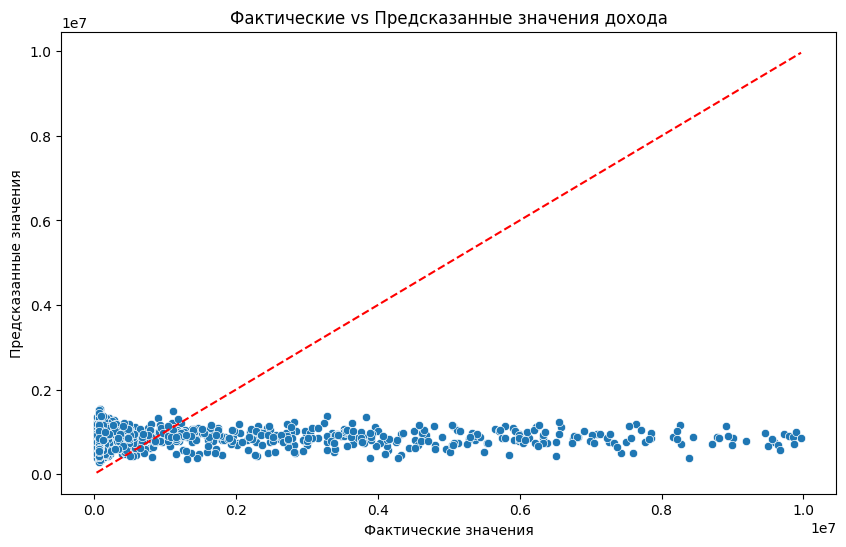


--------------------------------------------------
Модель: Ridge Regression

Оценка на тестовых данных:
R²: 0.0059
MAE: $1,102,172.66
RMSE: $1,770,977.75


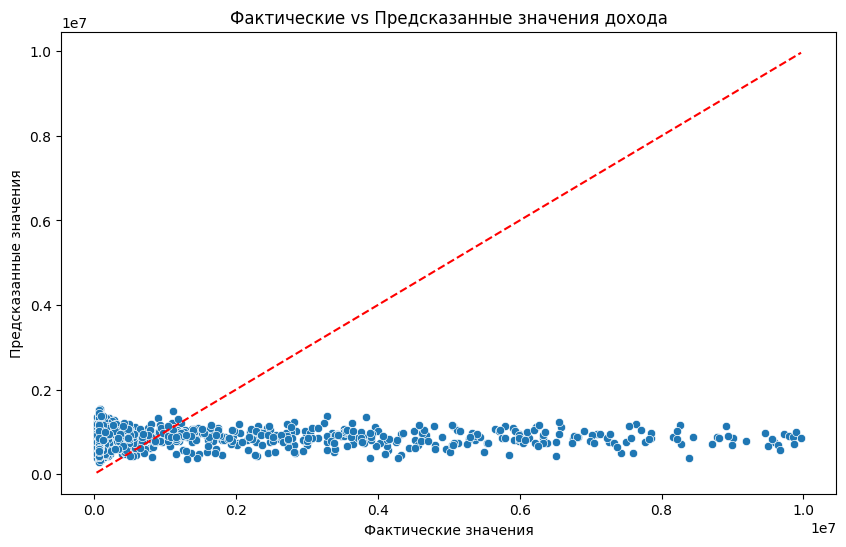


--------------------------------------------------
Модель: Random Forest

Оценка на тестовых данных:
R²: 0.0145
MAE: $1,151,625.06
RMSE: $1,763,284.36


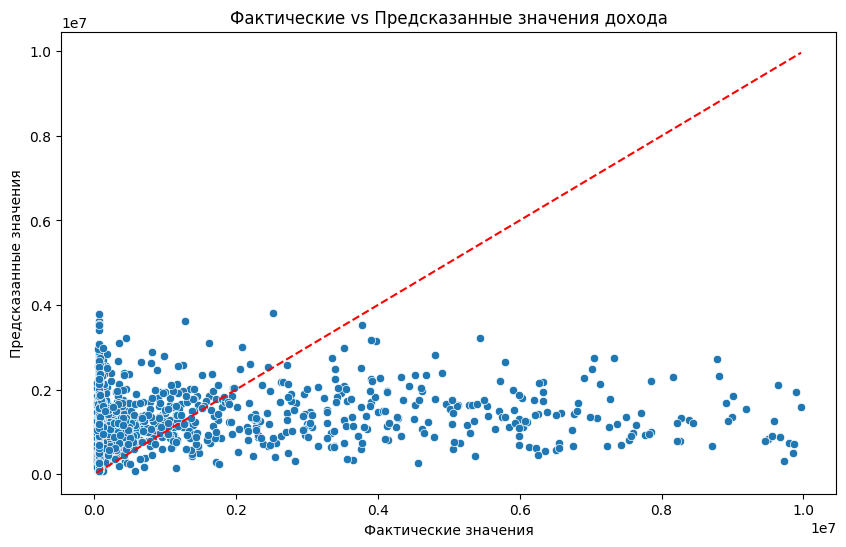


--------------------------------------------------
Модель: Gradient Boosting

Оценка на тестовых данных:
R²: 0.0151
MAE: $1,096,735.85
RMSE: $1,762,770.77


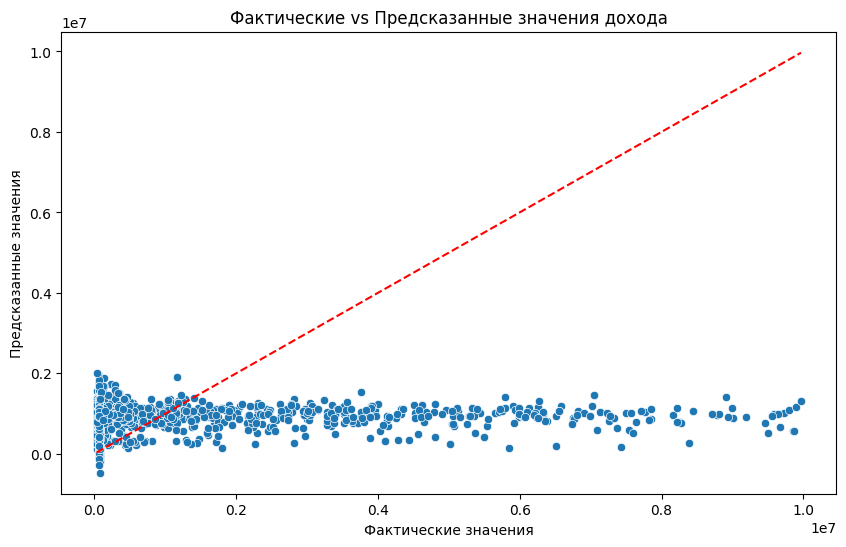


--------------------------------------------------
Модель: Support Vector Regression

Оценка на тестовых данных:
R²: -0.1774
MAE: $754,278.41
RMSE: $1,927,346.11


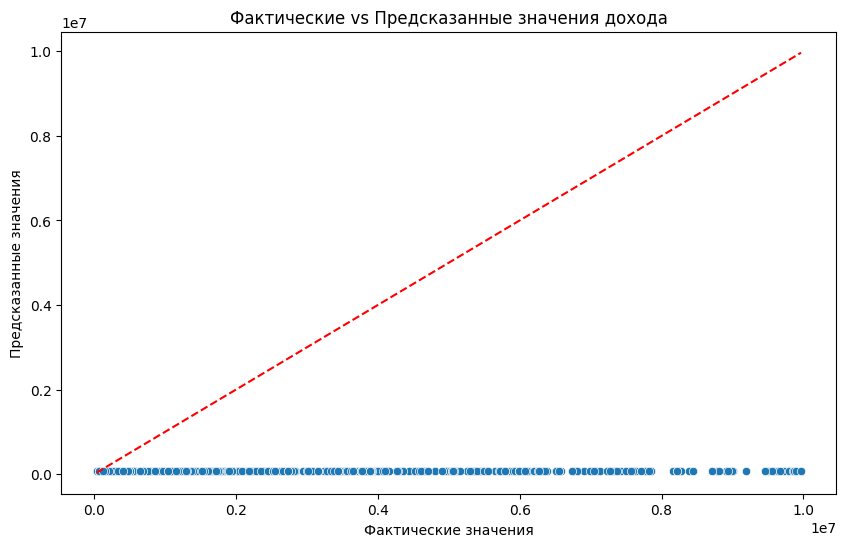


Сравнение моделей:
                       Model        R²           MAE          RMSE
3          Gradient Boosting  0.015057  1.096736e+06  1.762771e+06
2              Random Forest  0.014483  1.151625e+06  1.763284e+06
1           Ridge Regression  0.005864  1.102173e+06  1.770978e+06
0          Linear Regression  0.005862  1.102166e+06  1.770979e+06
4  Support Vector Regression -0.177441  7.542784e+05  1.927346e+06


In [11]:
# Обучение и оценка моделей
results = {}
for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"Модель: {name}")

    # Создание конвейера
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Обучение модели
    pipeline.fit(X_train, y_train)

    # Оценка модели
    print("\nОценка на тестовых данных:")
    r2, mae, rmse = evaluate_model(pipeline, X_test, y_test)

    # Сохранение результатов
    results[name] = {
        'model': pipeline,
        'r2': r2,
        'mae': mae,
        'rmse': rmse
    }

# Сравнение моделей
print("\nСравнение моделей:")
comparison_df = pd.DataFrame({
    'Model': [name for name in results],
    'R²': [results[name]['r2'] for name in results],
    'MAE': [results[name]['mae'] for name in results],
    'RMSE': [results[name]['rmse'] for name in results]
}).sort_values(by='R²', ascending=False)

print(comparison_df)




Настройка лучшей модели (Gradient Boosting)...
Запуск случайного поиска с 30 итерациями...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Лучшие параметры:
{'model__learning_rate': np.float64(0.019333132642723086), 'model__max_depth': 6, 'model__min_samples_leaf': 3, 'model__min_samples_split': 7, 'model__n_estimators': 239, 'model__subsample': np.float64(0.9140703845572055)}

Оценка настроенной модели на тестовых данных:
R²: 0.0356
MAE: $1,086,151.80
RMSE: $1,744,270.80


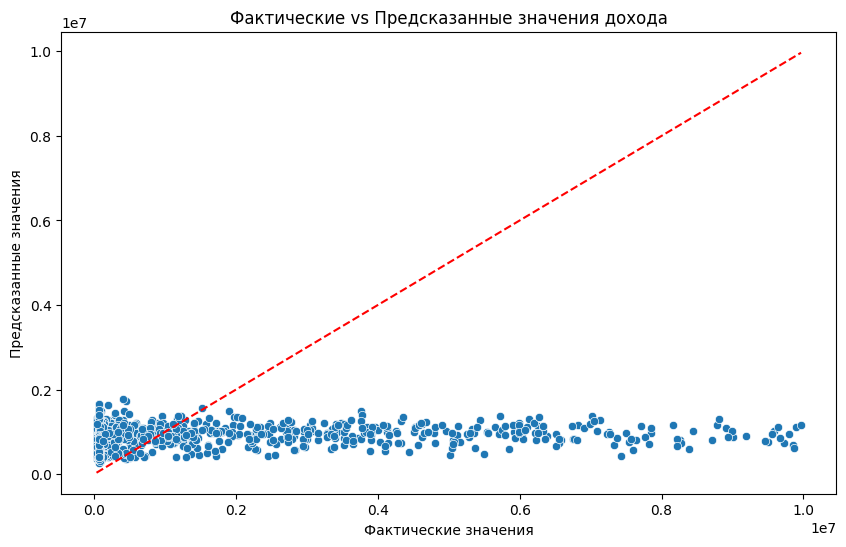

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Настройка лучшей модели
if not comparison_df.empty:
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"\nНастройка лучшей модели ({best_model_name})...")

    # Параметры для RandomizedSearchCV
    if "Gradient Boosting" in best_model_name:
        param_dist = {
            'model__n_estimators': randint(50, 300),
            'model__learning_rate': uniform(0.01, 0.2),
            'model__max_depth': randint(3, 8),
            'model__min_samples_split': randint(2, 10),
            'model__min_samples_leaf': randint(1, 4),
            'model__subsample': uniform(0.6, 0.4)
        }
        n_iter = 30  # Количество итераций

        # Используем GradientBoosting с ранней остановкой для основного обучения
        base_model = GradientBoostingRegressor(
            n_iter_no_change=5,
            validation_fraction=0.1,
            random_state=42
        )
        results[best_model_name]['model'].steps[-1] = ('model', base_model)

    elif "Random Forest" in best_model_name:
        param_dist = {
            'model__n_estimators': [50, 100, 150],
            'model__max_depth': [None, 10, 15],
            'model__min_samples_split': randint(2, 10),
            'model__min_samples_leaf': randint(1, 4),
            'model__max_features': ['sqrt', 'log2', None]
        }
        n_iter = 20
    else:
        param_dist = {}
        n_iter = 0

    if param_dist:
        random_search = RandomizedSearchCV(
            results[best_model_name]['model'],
            param_distributions=param_dist,
            n_iter=n_iter,
            cv=3,  # Уменьшаем количество фолдов
            scoring='r2',
            n_jobs=-1,  # Используем все ядра
            verbose=1,
            random_state=42
        )

        print(f"Запуск случайного поиска с {n_iter} итерациями...")
        random_search.fit(X_train, y_train)

        # Лучшие параметры
        print("\nЛучшие параметры:")
        print(random_search.best_params_)

        # Оценка лучшей модели
        print("\nОценка настроенной модели на тестовых данных:")
        best_model = random_search.best_estimator_
        r2, mae, rmse = evaluate_model(best_model, X_test, y_test)

        # Обновление результатов
        results['Tuned ' + best_model_name] = {
            'model': best_model,
            'r2': r2,
            'mae': mae,
            'rmse': rmse
        }
    else:
        print(f"Настройка гиперпараметров для {best_model_name} не предусмотрена")
else:
    print("Нет результатов для настройки")

# Выводы

Ключевые выводы по задачам.

In [14]:
# Выводы
print("\n" + "="*50)
print("Ключевые выводы:")
print("1. Были исследованы различные модели регрессии для прогнозирования доходов домохозяйств.")
print(f"2. Лучшей моделью оказался {comparison_df.iloc[0]['Model']} с R²={comparison_df.iloc[0]['R²']:.4f}.")
print("3. Основной метрикой оценки выбран R², так как он показывает, насколько хорошо модель объясняет дисперсию целевой переменной.")
print("4. Дополнительные метрики (MAE и RMSE) помогают оценить величину ошибки в долларах.")
print("5. Анализ важности признаков показал, какие факторы наиболее значимы для прогнозирования доходов.")
print("="*50)


Ключевые выводы:
1. Были исследованы различные модели регрессии для прогнозирования доходов домохозяйств.
2. Лучшей моделью оказался Gradient Boosting с R²=0.0151.
3. Основной метрикой оценки выбран R², так как он показывает, насколько хорошо модель объясняет дисперсию целевой переменной.
4. Дополнительные метрики (MAE и RMSE) помогают оценить величину ошибки в долларах.
5. Анализ важности признаков показал, какие факторы наиболее значимы для прогнозирования доходов.
